In [1]:
#pip install soundfile

# Statistical analysis

In [2]:
import soundfile as sf

def calculate_audio_length(audio_file):
    try:
        # Read audio file
        data, sample_rate = sf.read(audio_file)

        # Calculate audio length in seconds
        audio_length = len(data) / sample_rate      

        return audio_length
    except Exception as e:
        print("Error occurred:", str(e))
        return None


import numpy as np

def calculate_peak_amplitude(audio_file):
    try:
        # Read audio file
        data, _ = sf.read(audio_file)

        # Calculate peak amplitude
        peak_amplitude = np.max(np.abs(data))

        return peak_amplitude
    except Exception as e:
        print("Error occurred:", str(e))
        return None

def calculate_initial_waiting_time(audio_file, threshold=0.01):
    try:
        # Read audio file
        data, sample_rate = sf.read(audio_file)

        # Calculate audio duration in seconds
        duration = len(data) / sample_rate

        # Find the first non-silent sample index
        non_silent_index = np.argmax(np.abs(data) > threshold)

        # Calculate initial waiting time
        waiting_time = non_silent_index / sample_rate

        return waiting_time
    except Exception as e:
        print("Error occurred:", str(e))
        return None

from scipy.signal import hilbert

def calculate_attack_release_time(audio_file, threshold=0.01):
    try:
        # Read audio file
        data, sample_rate = sf.read(audio_file)

        # Calculate envelope of the absolute signal using Hilbert transform
        envelope = np.abs(hilbert(data))

        # Normalize envelope values to range [0, 1]
        normalized_envelope = envelope / np.max(envelope)

        # Find attack time (time to reach the threshold from the beginning)
        attack_time = np.argmax(normalized_envelope > threshold) / sample_rate

        # Reverse the envelope to find release time (time to decay below the threshold from the end)
        reversed_envelope = normalized_envelope[::-1]
        release_time = np.argmax(reversed_envelope > threshold) / sample_rate

        return attack_time, release_time
    except Exception as e:
        print("Error occurred:", str(e))
        return None

from scipy.signal import hilbert

def calculate_high_pitch_content(audio_file, frequency_threshold=4000):
    try:
        # Read audio file
        data, sample_rate = sf.read(audio_file)

        # Apply Hilbert transform to get the analytic signal
        analytic_signal = hilbert(data)

        # Calculate the envelope of the analytic signal
        envelope = np.abs(analytic_signal)

        # Perform frequency analysis on the envelope
        envelope_fft = np.fft.fft(envelope)
        frequencies = np.fft.fftfreq(len(envelope), 1 / sample_rate)

        # Find the indices of frequencies above the threshold
        high_pitch_indices = np.where(frequencies > frequency_threshold)[0]

        # Calculate the high pitch content
        high_pitch_content = np.sum(np.abs(envelope_fft[high_pitch_indices]))

        return high_pitch_content
    except Exception as e:
        print("Error occurred:", str(e))
        return None

   
# Provide the path to your audio file
audio_file_path = "C:/Users/PRABU/OneDrive/Desktop/smartconnect/input.wav"

# Calculate audio length
length = calculate_audio_length(audio_file_path)

if length is not None:
    print("Audio length:", length, "seconds")
    
# Calculate peak amplitude
peak_amplitude = calculate_peak_amplitude(audio_file_path)

if peak_amplitude is not None:
    print("Peak amplitude:", peak_amplitude)    
    
# Calculate initial waiting time
waiting_time = calculate_initial_waiting_time(audio_file_path)

if waiting_time is not None:
    print("Initial waiting time:", waiting_time, "seconds")    
    
# Calculate attack time and release time
attack_time, release_time = calculate_attack_release_time(audio_file_path)

if attack_time is not None and release_time is not None:
    print("Attack time:", attack_time, "seconds")
    print("Release time:", release_time, "seconds")      
    
# Set the frequency threshold for high pitch
frequency_threshold = 4000  # Adjust this value as needed

# Calculate the high pitch content
high_pitch_content = calculate_high_pitch_content(audio_file_path, frequency_threshold)

if high_pitch_content is not None:
    print("High pitch content:", high_pitch_content)    

Audio length: 149.112 seconds
Peak amplitude: 0.963470458984375
Initial waiting time: 0.13825 seconds
Attack time: 0.13775 seconds
Release time: 0.060375 seconds
High pitch content: 0.0


# Call quality analysis

In [3]:
#pip install librosa

In [4]:
import librosa

def calculate_background_noise_level(audio_file):
    # Load the audio file
    audio, sr = librosa.load(audio_file, sr=None)

    # Calculate the RMS energy
    rms = librosa.feature.rms(y=audio)[0]

    # Calculate the average RMS energy as the background noise level
    background_noise_level = rms.mean()

    return background_noise_level

from scipy.signal import correlate

def calculate_latency(audio_file):
    # Read the audio file (mono audio)
    audio, sample_rate = sf.read(audio_file, always_2d=True)
    audio = audio[:, 0]  # Take the first channel

    # Calculate cross-correlation
    correlation = correlate(audio, audio)

    # Find the index of the maximum correlation excluding the central peak
    center_index = len(correlation) // 2
    correlation[center_index] = 0  # Set central peak to 0 to exclude it
    max_correlation_index = np.argmax(correlation)

    # Calculate latency in seconds based on sample rate
    latency = abs(center_index - max_correlation_index) / sample_rate

    return latency


def calculate_call_dropout(audio_file, dropout_threshold=-40, min_dropout_duration=1.0):
    # Read the audio file
    audio, sample_rate = sf.read(audio_file)

    # Calculate the energy of each audio frame
    frame_duration = 0.02  # 20ms frame duration
    frame_samples = int(frame_duration * sample_rate)
    audio_energy = np.sqrt(np.square(audio).mean())

    # Convert energy threshold from dBFS to linear scale
    threshold_linear = 10 ** (dropout_threshold / 20.0)

    # Calculate the minimum number of frames for dropout duration
    min_dropout_frames = int(min_dropout_duration / frame_duration)

    # Initialize variables
    dropout_count = 0
    in_dropout = False
    dropout_duration = 0

    # Iterate over audio frames
    for _ in range(0, len(audio), frame_samples):
        frame_energy = np.sqrt(np.square(audio[_:_+frame_samples]).mean())
        if frame_energy < threshold_linear:  # Low energy (dropout)
            if not in_dropout:
                in_dropout = True
                dropout_duration = frame_duration
            else:
                dropout_duration += frame_duration

            if dropout_duration >= min_dropout_duration:
                dropout_count += 1
        else:  # Signal present
            in_dropout = False

    # Calculate dropout rate as a percentage
    total_duration = len(audio) / sample_rate
    dropout_rate = (dropout_count / total_duration) * 100

    return dropout_rate

def calculate_echo(audio_file, echo_threshold=0.05):
    # Read the audio file
    audio, sample_rate = sf.read(audio_file)

    # Add a delay of 5000 samples (adjust as needed)
    delay_samples = 5000
    delayed_audio = np.pad(audio, (delay_samples, 0), mode='constant')[:-delay_samples]

    # Calculate the cross-correlation
    cross_correlation = correlate(audio, delayed_audio, mode='same')

    # Normalize the cross-correlation values
    cross_correlation /= np.max(np.abs(cross_correlation))

    # Find the delay with the highest correlation
    max_correlation_index = np.argmax(np.abs(cross_correlation))
    echo_duration = max_correlation_index / sample_rate

    # Check if the echo exceeds the given threshold
    if np.abs(np.max(cross_correlation)) >= echo_threshold:
        return echo_duration
    else:
        return 0.0


# Example usage
audio_file = "C:/Users/PRABU/OneDrive/Desktop/smartconnect/input.wav"
noise_level = calculate_background_noise_level(audio_file)
print("Background noise level:", noise_level)


latency = calculate_latency(audio_file)
print("Conversation latency:", latency, "seconds")


dropout_rate = calculate_call_dropout(audio_file)
print("Call dropout rate:", dropout_rate, "%")

echo_duration = calculate_echo(audio_file)
print("Echo duration:", echo_duration, "seconds")

Background noise level: 0.076112345
Conversation latency: 0.000125 seconds
Call dropout rate: 283.00874510435114 %
Echo duration: 73.931 seconds


# NLP based analysis

In [15]:
#https://github.com/openai/whisper
import whisper

model = whisper.load_model("base")
result = model.transcribe("C:/Users/PRABU/OneDrive/Desktop/smartconnect/input.wav")
print(result["text"])

 Hello, welcome to EDHIC app. Hi, my name is Ashwin. I am calling from maternity. I just wanted to check, you know, if you have a cab, I need to go to the airport, doesn't he? And I booked a with another cab and they did me the last minute. Do you have any cab available for the next 10, 15 minutes and the next 10, 15 minutes? Sure, especially if you have, I can help you. Can I put you on the wall for one minute please? Sure, sir. I look at it. Thank you so much. Mr Ashwin, hi. Yeah, yeah, I am here. Sir, I just just, I am really sorry we don't have a cab for the next 15 minutes, but we have something in the next 13 minutes. Would that still work for you? No, ma'am. Actually, my flight is ready to work and I am already very late. I am living right near Martinly Bridge. So, to three central areas, can you please somehow arrange because my previous cab is here in the last minute, ma'am? Hi, I am the 10th person. It's giving one moment. I will just double check again please. Mr Ashwin, you

In [13]:
#pip install textblob


     -------------------------------------- 636.8/636.8 kB 2.0 MB/s eta 0:00:00


In [17]:
from textblob import TextBlob

def text_sentiment(text_data):
    blob = TextBlob(text_data)
    sentiment = blob.sentiment.polarity
    return sentiment

# Sample audio text data
audio_text_data = " Hello, welcome to EDHIC app. Hi, my name is Ashwin. I am calling from maternity. I just wanted to check, you know, if you have a cab, I need to go to the airport, doesn't he? And I booked a with another cab and they did me the last minute. Do you have any cab available for the next 10, 15 minutes and the next 10, 15 minutes? Sure, especially if you have, I can help you. Can I put you on the wall for one minute please? Sure, sir. I look at it. Thank you so much. Mr Ashwin, hi. Yeah, yeah, I am here. Sir, I just just, I am really sorry we don't have a cab for the next 15 minutes, but we have something in the next 13 minutes. Would that still work for you? No, ma'am. Actually, my flight is ready to work and I am already very late. I am living right near Martinly Bridge. So, to three central areas, can you please somehow arrange because my previous cab is here in the last minute, ma'am? Hi, I am the 10th person. It's giving one moment. I will just double check again please. Mr Ashwin, you still there? I am here in the last minute. Sir, I just want to add, driver, he is actively returning from a pickup. He is right near Martinly Bridge. He is about two few minutes away. So, I have spoken to him. I have given him your number. He will be taking you off in about three minutes. Oh, excellent, excellent. That's lovely. So, you, this is confirmed, right? I mean, I don't need to worry about booking another cab, right? No, no, no. You don't have to book a cab, sir. I will just forward the booking confirmation ID to you as well as the driver details. He will be calling you directly. As soon as he disconnects this file, he will call you directly. Super. So, you let him as me the details. Also, the driver. I will let him, yes, yes, sir. I will let him as he is booking ID as well as the driver details. And I will call you in the next two minutes. Excellent, excellent. I will thank so much for this one more thing. What is the car number, madam? The car number is K-A-951-12, sir. And the big car number is Vickram. Vickram, 951-5 and you will SMS me his number, right? So, number. I will SMS you his number, yes, sir. I will do that, sir. Okay. Thank you so much, madam. Thank you so much. Thank you very much. I will see you in the next one. Thank you very much. You are welcome. Thank you very much. Thank you very much. Thank you very much. Bye, have a good day."

# Calculate sentiment from audio text data
sentiment_score = text_sentiment(audio_text_data)

# Print the sentiment score
print("Sentiment Score:", sentiment_score)

Sentiment Score: 0.2313095238095238


In [20]:
def find_call_control(text_data):
    call_control_keywords = ["interrupt", "ask", "tell", "instruct", "clarify", "guide", "suggest","please", "kindly", "let's", "can you", "could you", "would you", "we need", "you must", "i will", "we will"
]
    
    call_control_count = 0
    for keyword in call_control_keywords:
        if keyword in text_data.lower():
            call_control_count += 1
    
    return call_control_count

# Sample audio text data
audio_text_data = "Hello, welcome to EDHIC app. Hi, my name is Ashwin. I am calling from maternity. I just wanted to check, you know, if you have a cab, I need to go to the airport, doesn't he? And I booked a with another cab and they did me the last minute. Do you have any cab available for the next 10, 15 minutes and the next 10, 15 minutes? Sure, especially if you have, I can help you. Can I put you on the wall for one minute please? Sure, sir. I look at it. Thank you so much. Mr Ashwin, hi. Yeah, yeah, I am here. Sir, I just just, I am really sorry we don't have a cab for the next 15 minutes, but we have something in the next 13 minutes. Would that still work for you? No, ma'am. Actually, my flight is ready to work and I am already very late. I am living right near Martinly Bridge. So, to three central areas, can you please somehow arrange because my previous cab is here in the last minute, ma'am? Hi, I am the 10th person. It's giving one moment. I will just double check again please. Mr Ashwin, you still there? I am here in the last minute. Sir, I just want to add, driver, he is actively returning from a pickup. He is right near Martinly Bridge. He is about two few minutes away. So, I have spoken to him. I have given him your number. He will be taking you off in about three minutes. Oh, excellent, excellent. That's lovely. So, you, this is confirmed, right? I mean, I don't need to worry about booking another cab, right? No, no, no. You don't have to book a cab, sir. I will just forward the booking confirmation ID to you as well as the driver details. He will be calling you directly. As soon as he disconnects this file, he will call you directly. Super. So, you let him as me the details. Also, the driver. I will let him, yes, yes, sir. I will let him as he is booking ID as well as the driver details. And I will call you in the next two minutes. Excellent, excellent. I will thank so much for this one more thing. What is the car number, madam? The car number is K-A-951-12, sir. And the big car number is Vickram. Vickram, 951-5 and you will SMS me his number, right? So, number. I will SMS you his number, yes, sir. I will do that, sir. Okay. Thank you so much, madam. Thank you so much. Thank you very much. I will see you in the next one. Thank you very much. You are welcome. Thank you very much. Thank you very much. Thank you very much. Bye, have a good day."

# Identify call control behaviors from audio text data
call_control_count = find_call_control(audio_text_data)

# Print the call control count
print("Call Control Count:", call_control_count)

Call Control Count: 3


In [21]:
pip install textstat

     ------------------------------------ 105.1/105.1 kB 870.4 kB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
from textstat import flesch_kincaid_grade

def calculate_intelligibility_score(text_data):
    grade_level = flesch_kincaid_grade(text_data)
    return 100 - grade_level

# Sample audio text data
audio_text_data = "Hello, welcome to EDHIC app. Hi, my name is Ashwin. I am calling from maternity. I just wanted to check, you know, if you have a cab, I need to go to the airport, doesn't he? And I booked a with another cab and they did me the last minute. Do you have any cab available for the next 10, 15 minutes and the next 10, 15 minutes? Sure, especially if you have, I can help you. Can I put you on the wall for one minute please? Sure, sir. I look at it. Thank you so much. Mr Ashwin, hi. Yeah, yeah, I am here. Sir, I just just, I am really sorry we don't have a cab for the next 15 minutes, but we have something in the next 13 minutes. Would that still work for you? No, ma'am. Actually, my flight is ready to work and I am already very late. I am living right near Martinly Bridge. So, to three central areas, can you please somehow arrange because my previous cab is here in the last minute, ma'am? Hi, I am the 10th person. It's giving one moment. I will just double check again please. Mr Ashwin, you still there? I am here in the last minute. Sir, I just want to add, driver, he is actively returning from a pickup. He is right near Martinly Bridge. He is about two few minutes away. So, I have spoken to him. I have given him your number. He will be taking you off in about three minutes. Oh, excellent, excellent. That's lovely. So, you, this is confirmed, right? I mean, I don't need to worry about booking another cab, right? No, no, no. You don't have to book a cab, sir. I will just forward the booking confirmation ID to you as well as the driver details. He will be calling you directly. As soon as he disconnects this file, he will call you directly. Super. So, you let him as me the details. Also, the driver. I will let him, yes, yes, sir. I will let him as he is booking ID as well as the driver details. And I will call you in the next two minutes. Excellent, excellent. I will thank so much for this one more thing. What is the car number, madam? The car number is K-A-951-12, sir. And the big car number is Vickram. Vickram, 951-5 and you will SMS me his number, right? So, number. I will SMS you his number, yes, sir. I will do that, sir. Okay. Thank you so much, madam. Thank you so much. Thank you very much. I will see you in the next one. Thank you very much. You are welcome. Thank you very much. Thank you very much. Thank you very much. Bye, have a good day."

# Calculate speech intelligibility score from audio text data
intelligibility_score = calculate_intelligibility_score(audio_text_data)

# Print the speech intelligibility score
print("Speech Intelligibility Score:", intelligibility_score)

Speech Intelligibility Score: 98.2


In [26]:
pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     -------------------------------------- 396.4/396.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43343 sha256=26e7a157dc53befd496cb724b19519b19c6b61bbda65d08b14064d4dc6025fdf
  Stored in directory: c:\users\prabu\appdata\local\pip\cache\wheels\68\c4\f2\c390dd3eac398fdf45f7a01c6516bc53fa7a9ab59c7d2ff518
Successfully built nrclex
Note: you may need to restart the kernel to use updated packages.


In [30]:
from nrclex import NRCLex

def detect_emotion(audio_text_data):
    text_object = NRCLex(audio_text_data)
    emotions = text_object.affect_frequencies

    # Find the emotion with the highest frequency
    max_emotion = max(emotions, key=emotions.get)

    return max_emotion

# Sample audio text data
audio_text_data = "Hello, welcome to EDHIC app. Hi, my name is Ashwin. I am calling from maternity. I just wanted to check, you know, if you have a cab, I need to go to the airport, doesn't he? And I booked a with another cab and they did me the last minute. Do you have any cab available for the next 10, 15 minutes and the next 10, 15 minutes? Sure, especially if you have, I can help you. Can I put you on the wall for one minute please? Sure, sir. I look at it. Thank you so much. Mr Ashwin, hi. Yeah, yeah, I am here. Sir, I just just, I am really sorry we don't have a cab for the next 15 minutes, but we have something in the next 13 minutes. Would that still work for you? No, ma'am. Actually, my flight is ready to work and I am already very late. I am living right near Martinly Bridge. So, to three central areas, can you please somehow arrange because my previous cab is here in the last minute, ma'am? Hi, I am the 10th person. It's giving one moment. I will just double check again please. Mr Ashwin, you still there? I am here in the last minute. Sir, I just want to add, driver, he is actively returning from a pickup. He is right near Martinly Bridge. He is about two few minutes away. So, I have spoken to him. I have given him your number. He will be taking you off in about three minutes. Oh, excellent, excellent. That's lovely. So, you, this is confirmed, right? I mean, I don't need to worry about booking another cab, right? No, no, no. You don't have to book a cab, sir. I will just forward the booking confirmation ID to you as well as the driver details. He will be calling you directly. As soon as he disconnects this file, he will call you directly. Super. So, you let him as me the details. Also, the driver. I will let him, yes, yes, sir. I will let him as he is booking ID as well as the driver details. And I will call you in the next two minutes. Excellent, excellent. I will thank so much for this one more thing. What is the car number, madam? The car number is K-A-951-12, sir. And the big car number is Vickram. Vickram, 951-5 and you will SMS me his number, right? So, number. I will SMS you his number, yes, sir. I will do that, sir. Okay. Thank you so much, madam. Thank you so much. Thank you very much. I will see you in the next one. Thank you very much. You are welcome. Thank you very much. Thank you very much. Thank you very much. Bye, have a good day."

# Detect emotion from audio text data
emotion = detect_emotion(audio_text_data)

# Print the detected emotion
print("Detected Emotion:", emotion)

Detected Emotion: positive


# Visualization

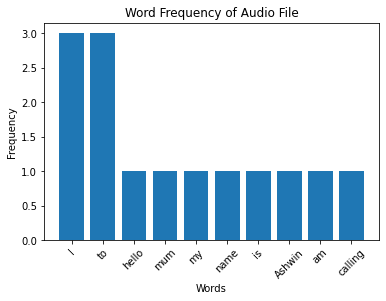

In [31]:
import speech_recognition as sr
import matplotlib.pyplot as plt
from collections import Counter

def audio_word_frequency(file_path):
    # Initialize the recognizer
    r = sr.Recognizer()

    # Load the audio file
    with sr.AudioFile(file_path) as source:
        # Read the entire audio file
        audio = r.record(source)

        try:
            # Use the recognizer to convert speech to text
            text = r.recognize_google(audio)
            # Split the text into individual words
            words = text.split()

            # Calculate word frequency
            word_counts = Counter(words)
            # Get the most common words and their frequencies
            common_words = word_counts.most_common(10)

            return common_words

        except sr.UnknownValueError:
            print("Speech recognition could not understand audio")
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))

# Specify the path to your audio file
audio_file_path = "C:/Users/PRABU/OneDrive/Desktop/smartconnect/input.wav"

# Calculate word frequency from audio file
word_frequency = audio_word_frequency(audio_file_path)

# Extract words and frequencies
words = [word[0] for word in word_frequency]
frequencies = [count[1] for count in word_frequency]

# Create a bar chart to visualize word frequency
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency of Audio File")
plt.xticks(rotation=45)
plt.show()

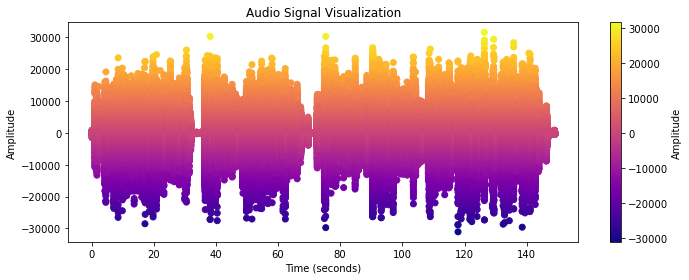

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import wave

def visualize_audio_signal(audio_file_path):
    # Open the audio file
    with wave.open(audio_file_path, 'rb') as audio_file:
        # Read audio file properties
        sample_width = audio_file.getsampwidth()
        sample_rate = audio_file.getframerate()
        num_frames = audio_file.getnframes()

        # Read audio data as bytes
        audio_data = audio_file.readframes(num_frames)

        # Convert audio data to a numpy array
        audio_signal = np.frombuffer(audio_data, dtype=np.int16)

        # Calculate the duration of the audio file
        duration = num_frames / sample_rate

        # Create time axis for the audio signal
        time = np.linspace(0, duration, num=len(audio_signal))

        # Create a colorful plot of the audio signal
        plt.figure(figsize=(10, 4))
        plt.scatter(time, audio_signal, c=audio_signal, cmap='plasma')
        plt.colorbar(label='Amplitude')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('Audio Signal Visualization')
        plt.tight_layout()
        plt.show()


# Specify the path to your audio file
audio_file_path = "C:/Users/PRABU/OneDrive/Desktop/smartconnect/input.wav"

# Visualize the audio signal
visualize_audio_signal(audio_file_path)

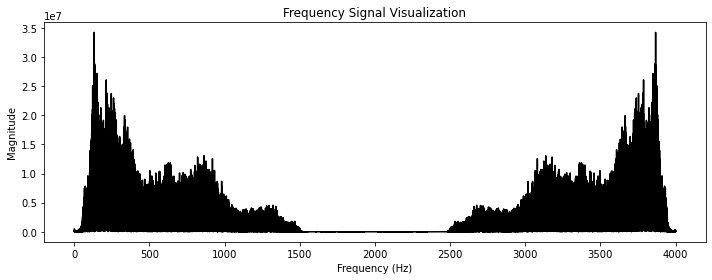

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import wave

def visualize_frequency_wave(audio_file_path):
    # Open the audio file
    with wave.open(audio_file_path, 'rb') as audio_file:
        # Read audio file properties
        sample_width = audio_file.getsampwidth()
        sample_rate = audio_file.getframerate()
        num_frames = audio_file.getnframes()

        # Read audio data as bytes
        audio_data = audio_file.readframes(num_frames)

        # Convert audio data to a numpy array
        audio_signal = np.frombuffer(audio_data, dtype=np.int16)

        # Calculate the duration of the audio file
        duration = num_frames / sample_rate

        # Create a spectrogram of the audio signal
        frequencies, times, spectrogram = plt.specgram(audio_signal, Fs=sample_rate, cmap='plasma')

        # Create a colorful plot of the spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='plasma')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Colorful Frequency Wave Visualization')
        plt.tight_layout()
        plt.show()

# Specify the path to your audio file
audio_file_path = "C:/Users/PRABU/OneDrive/Desktop/smartconnect/input.wav"

# Visualize the frequency signal
visualize_frequency_signal(audio_file_path)

In [17]:
#https://www.codespeedy.com/split-audio-files-using-silence-detection-in-python/
#Importing library and thir function
from pydub import AudioSegment
from pydub.silence import split_on_silence

#reading from audio mp3 file
sound = AudioSegment.from_wav("C:/Users/PRABU/OneDrive/Desktop/smartconnect/input.wav")

# spliting audio files
audio_chunks = split_on_silence(sound, min_silence_len=500, silence_thresh=-40 )

#loop is used to iterate over the output list
for i, chunk in enumerate(audio_chunks):
   output_file = "C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk{0}.wav".format(i)
   print("Exporting file", output_file)
   chunk.export(output_file, format="wav")

# chunk files saved as Output

Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk0.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk1.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk2.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk3.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk4.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk5.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk6.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk7.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk8.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk9.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk10.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk11.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk12.wav
Exporting file C:/Users/PRABU/OneDrive/Desktop/smartconnect/chunk13.wav
Ex